# Project 2: Photon-matter interaction — Monte Carlo simulation of X-ray imaging

## Introduction
In this project we are going to look at how electromagnetic waves in the form of X-rays can be used in medical imaging. By using a one-dimensional model we will see how intensity, contrast and dosage varies with energy. The method that will be used, Monte Carlo simulation, gives us more accuracy with more samples (i.e photons).

In [1]:
# Numpy to make life easy
import numpy as np
from numpy import linalg as la
# Matplotlib for plotting
import matplotlib.pyplot as plt

# Increase default font size
plt.rcParams.update({'font.size': 14})

# Import for progress meter
from tqdm import tqdm, trange

from numba import jit, prange



### Problem 1

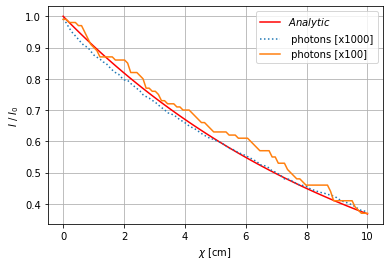

In [27]:

N_steps = 100                                     
N_photons = 1000 
L = np.linspace(0,10,N_steps)
dx = 10/N_steps
def poa(dx,N_steps,N_photons):              #Function that sends a photon through a material.
                                            #a random number, determine if the photons keeps passing 
    mu = 0.1                                #through at every discrete dx.
    p_count = np.zeros(N_steps)
    
   
    for j in range(N_photons):
        for i in range(0, N_steps):
            z = np.random.rand()
            if z > mu*dx:
                p_count[i] += 1
                 
            else:
                break
    return (p_count/N_photons)

P1 = poa(dx,N_steps,1000)

P2 = poa(dx,N_steps,100)

plt.figure(1)
plt.plot(L,np.exp(-0.1*L), 'r', label = "$Analytic$", ) #Analytical solution for mu = 0.1
plt.plot(L, P1, ':',label = " photons [x1000]")
plt.plot(L, P2, '-',label = " photons [x100]")
plt.xlabel("$\chi$ [cm]")
plt.ylabel("$I$ / $I_0$")
plt.legend()
plt.grid()
plt.show()


##  Discussion 

Dividing the length of the material in to discrete steps, dx, and knowing that the probability P depends on this, with the relation P =$\mu$*dx, one can clearly see that $\mu$ and dx must act inversely proportional so that one can limit P to one. The considerations one has to make when choosing an adequate step size is that it should be able to adapt to a changing attenuation coefficient. For every one of these discrete steps a random number generator is used to determine the outcome. By using this type of simulation one can not expect that every photon will pass through. Looking at the plot for the analytical curve it is easy to observe that just under 40% of the photons will pass through the material. The number of photons that pass through will not depend solely on $\mu$ and dx, but also the photons energy. For more accurate results more photons can be used in the simulations, as seen in the plots.

## Problem 2

## File extraction

In [70]:
tf = np.loadtxt('tissue.txt', delimiter = ',') #Tissue file

bf = np.loadtxt('bone.txt', delimiter = ',') #Bone file



## Density coefficients

In [71]:
rho_b = 1.92 #g/cm
rho_t = 1.02 #g/cm


## Attenuation

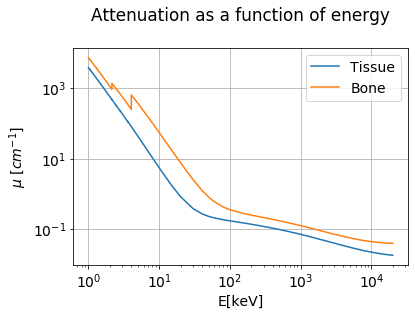

In [165]:
tf_att = tf[:,1]*1.02  #Slicing the txt files, and multiplying with density coefficient
tf_energy = tf[:,0]*1000 #Converting to keV
bf_att = bf[:,1]*1.92    #Multiplying with density coefficient
bf_energy = bf[:,0]*1000 #Converting to keV



plt.figure(2)
plt.loglog(tf_energy, tf_att, label = 'Tissue')
plt.loglog(bf_energy, bf_att, label = 'Bone')
plt.xlabel('E[keV]')
plt.ylabel("$\mu$ [$cm^{-1}$]")
plt.title("Attenuation as a function of energy\n")
plt.legend()
plt.grid()
plt.show()

## Intensity

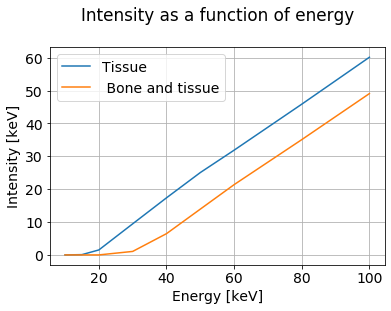

In [166]:

tf_for_att = tf_att[21:30]                 # Slicing the arrays given from the given files
tf_for_energy = tf_energy[21:30]           # such that one can obtain the acquired energies
bf_for_att = bf_att[21:30]                 # and attenuation coefficients.
bf_for_energy = bf_energy[21:30]

#--------------------------------

@jit(nopython = True)
def prob_of_attenuation(my, width, N_photons):
    slices = my.size
    
    dx = width / slices
    
    p_count = np.zeros(slices)
    
    for j in range(N_photons):   #Since numba and jit are not compatible with tqdm and trange,                            
        for i in range(slices):  #adjustments have been made to the code such that it works with numba 
            p = my[i] * dx       #and therefore runs faster.

            p_count[i] = p_count[i] + 1
            z = np.random.rand()
            if z < p:
                break
                
    return p_count[slices - 1] / N_photons

width = 3
N_steps = 1000

N_photons = 10000
num = tf_for_att.size
I_tissue = np.zeros(num)
I_bt = np.zeros(num)

for k in range(num):
    my_tissue = np.ones(N_steps) * tf_for_att[k]        #A nested loop to create the array for tissue
                                                        #and bone and tissue in combination
    my_bt = np.ones(N_steps) * tf_for_att[k]
    
    for i in range(int(N_steps/3),int((N_steps*2)/3)):  #Does also create their intensity arrays respectively
         my_bt[i] = bf_for_att[k]
    
    I_tissue[k] = prob_of_attenuation(my_tissue,width,N_photons) * tf_for_energy[k]
    
    I_bt[k] = prob_of_attenuation(my_bt,width,N_photons) * bf_for_energy[k]

    
    
    

plt.figure(3)
plt.plot(tf_for_energy, I_tissue, label = "Tissue")
plt.plot(bf_for_energy, I_bt, label = " Bone and tissue")
plt.xlabel("Energy [keV]")
plt.ylabel("Intensity [keV]")
plt.title("Intensity as a function of energy\n")
plt.legend()
plt.grid()
plt.show()



## Contrast

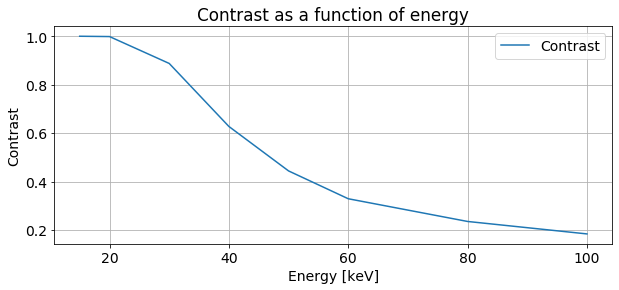

In [167]:
#contrast:
C = (I_tissue[1:9]-I_bt[1:9])/ I_tissue[1:9]         #Calculating the contrast with given values.
#print(C)
plt.figure(4,figsize=(10,4))
plt.plot(tf_for_energy[1:9], C, label = "Contrast")
plt.xlabel("Energy [keV]")
plt.ylabel("Contrast")
plt.title("Contrast as a function of energy")
plt.legend()
plt.grid()
plt.show()



## Photons and intensity

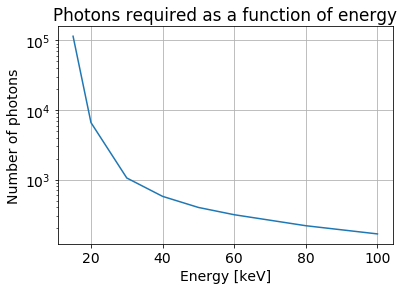

In [168]:

photons_required = 10000 / I_tissue[1:9]             #Calculating photons required given intensity 10MeV

plt.figure(5)
plt.semilogy(tf_for_energy[1:9], photons_required)
plt.ylabel("Number of photons")
plt.xlabel("Energy [keV]")
plt.title("Photons required as a function of energy")
plt.grid()
plt.show()


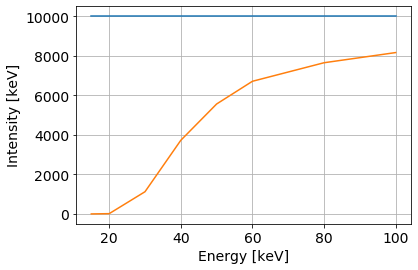

In [170]:
intensity1 = photons_required * I_tissue[1:9] #intensity for tissue
intensity2 = photons_required * I_bt[1:9]     #intensity for bone and tissue

plt.figure(6)
plt.plot(tf_for_energy[1:9], intensity1, label = "$I_1$")
plt.plot(tf_for_energy[1:9], intensity2, label = "$I_2$")
plt.xlabel("Energy [keV]")
plt.ylabel("Intensity [keV]")
plt.grid()
plt.show()

## Dose

<function matplotlib.pyplot.show(*args, **kw)>

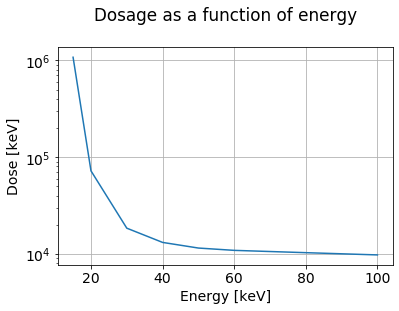

In [119]:
V_tissue = 3*1*rho_t                                       #Calculating D1 and D2   
V_bone = 2*rho_t*rho_b
D_1 = (photons_required * tf_for_energy[1:9])/V_tissue
D_2 = (photons_required * tf_for_energy[1:9])/V_bone


plt.figure(7)
plt.semilogy(tf_for_energy[1:9],D_1+D_2, )
plt.title("Dosage as a function of energy\n")
plt.xlabel("Energy [keV]")
plt.ylabel("Dose [keV]")
plt.grid()
plt.show



The energies that gives the best contrast are low energies (i.e 10-30keV). In this spectrum very few photons will pass through the assigned material and therefore one will achieve a good contrast.
To obtain good contrast with a low dose, the energy range 30-40keV should be used. In this range too much unnecessary ionizing radiation will be avoided and a one will get a good image.


## Problem 3

In [134]:
                                                        #Creating a function for shooting Ni x Nj photons.  
def poa2d(data,width,N_photons):                        #Takes in the given data and uses the built in 
    img = np.zeros((data.shape[0],data.shape[1]))       #function shape to find the form and size of  
    for x in trange(data.shape[0]):                     #the given arrays. The nested loop sends the photons
        for y in range (data.shape[1]):                 # in both i and j directions.
            column = data[x,y]
            res = prob_of_attenuation(column,width,N_photons)
            img[x,y] = res
    return img



100%|██████████| 128/128 [00:03<00:00, 41.84it/s]


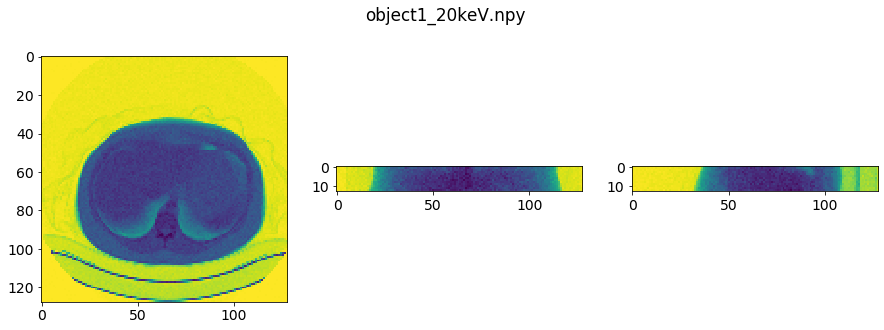

100%|██████████| 128/128 [00:03<00:00, 40.11it/s]


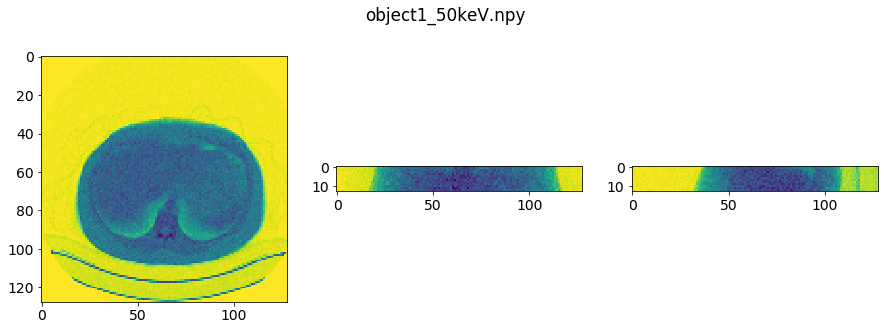

100%|██████████| 128/128 [00:03<00:00, 38.23it/s]


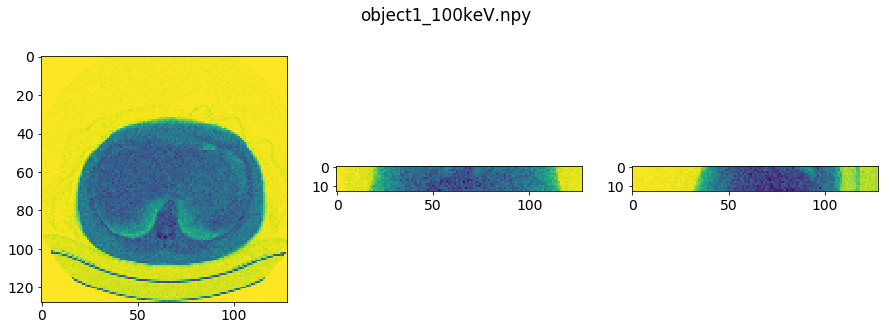

100%|██████████| 60/60 [00:02<00:00, 23.47it/s]


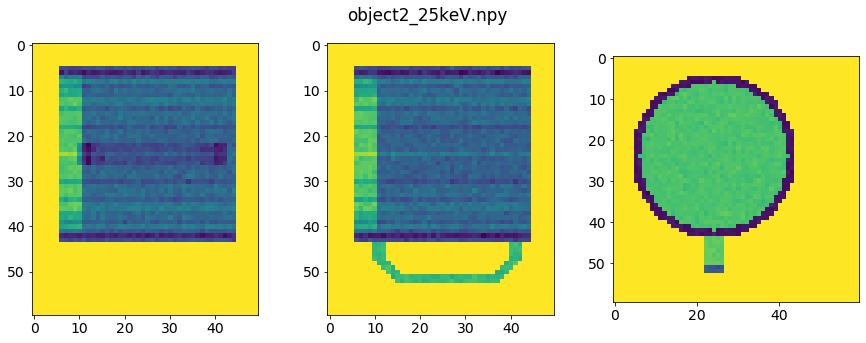

100%|██████████| 60/60 [00:02<00:00, 22.06it/s]


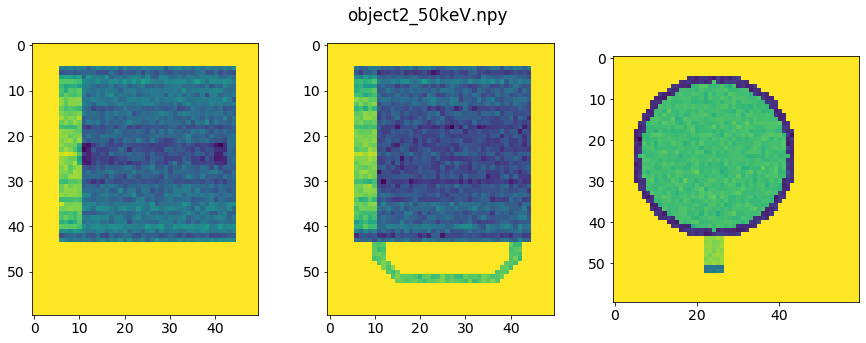

100%|██████████| 60/60 [00:02<00:00, 23.34it/s]


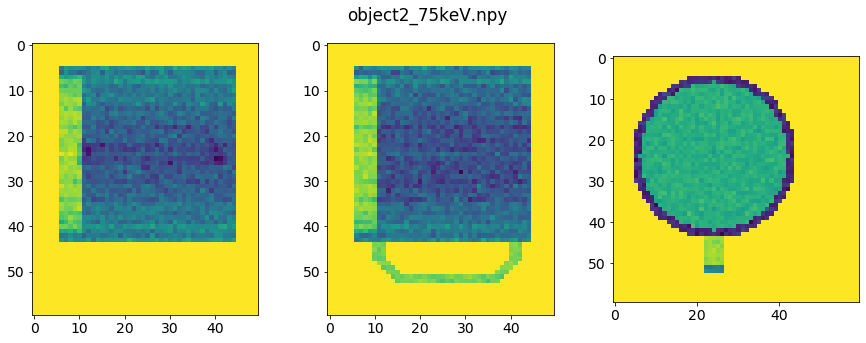

In [145]:
def poa3d(filename, N_photons, height, width, depth):
    
    data_x = np.load(filename)                          #Takes in the data in a given data set and loads it 
    data_y = np.rot90(data_x, 1, (2, 1))                #as a numpy array. np.rot90 
    data_z = np.rot90(data_y, 1, (0, 2))                #rotates given array 90 degrees
    
    fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize = (15, 5)) 
    fig.suptitle(filename)
    
    ax3.imshow(poa2d(data_x, height,N_photons))                #Plotting for x, y, z directions.
    ax2.imshow(poa2d(data_y, width,N_photons))                 #Using imshow for image plotting.
    ax1.imshow(poa2d(data_z, depth,N_photons))
    
    plt.show()
    
    
   

poa3d("object1_20keV.npy", 1000, 1, 1, 1)       #Calling the function for all given data sets.
poa3d("object1_50keV.npy", 1000, 1, 1, 1)
poa3d("object1_100keV.npy", 1000, 1, 1, 1)
poa3d("object2_25keV.npy", 1000, 1, 1, 1)
poa3d("object2_50keV.npy", 1000, 1, 1, 1)
poa3d("object2_75keV.npy", 1000, 1, 1, 1)

A one dimensional method has been used to image a 3D object by imaging in the x, y and z direction. Knowing the different energies used in the imaging one can see which of the energies gives the best contrast and image. Not taking dosage of the ionizing radiation in to account the low energies gives the best images. This is in sync with what we figured outn in Task 2. The contrast is higher for lower energies.

The objects being imaged are quite different. Object one looks like a cross section of a pair of lungs with the spine at around the point (60,90),  and the other looks like a coffee mug.

## Conclusion

Even though our one dimensional model is quite simple it can give good results. It has shown us that using more samples (i.e photons) gives more accurate data and we can image object with a fair amount of precision.